# How does the Maracaibo lake cover change V15--> V20?

In [20]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 




def correct_longitude(ds):    
    return ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})


def plot_map(ds,z,vmin,vmax,cmap,logscale,title,limits):
    
    """Scatter plot. Bit hacky. """

    try:
        x = ds.longitude
        y = ds.latitude
    except: #different sources call lat/lon different things
        x = ds.longitude_ERA
        y = ds.latitude_ERA
    
    z1 = ds[z]
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    
    #Cmaps, normalisations
    if logscale:
        norm = mc.LogNorm(vmin=vmin, vmax=vmax)
        z1 = abs(z1)
    else:
        norm = mc.Normalize(vmin=vmin, vmax=vmax)

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=100,c=cmap(norm(z1)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    if limits is not None:
        ax.set_xlim(limits['xlow'],limits['xhigh'])
        ax.set_ylim(limits['ylow'],limits['yhigh'])
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    

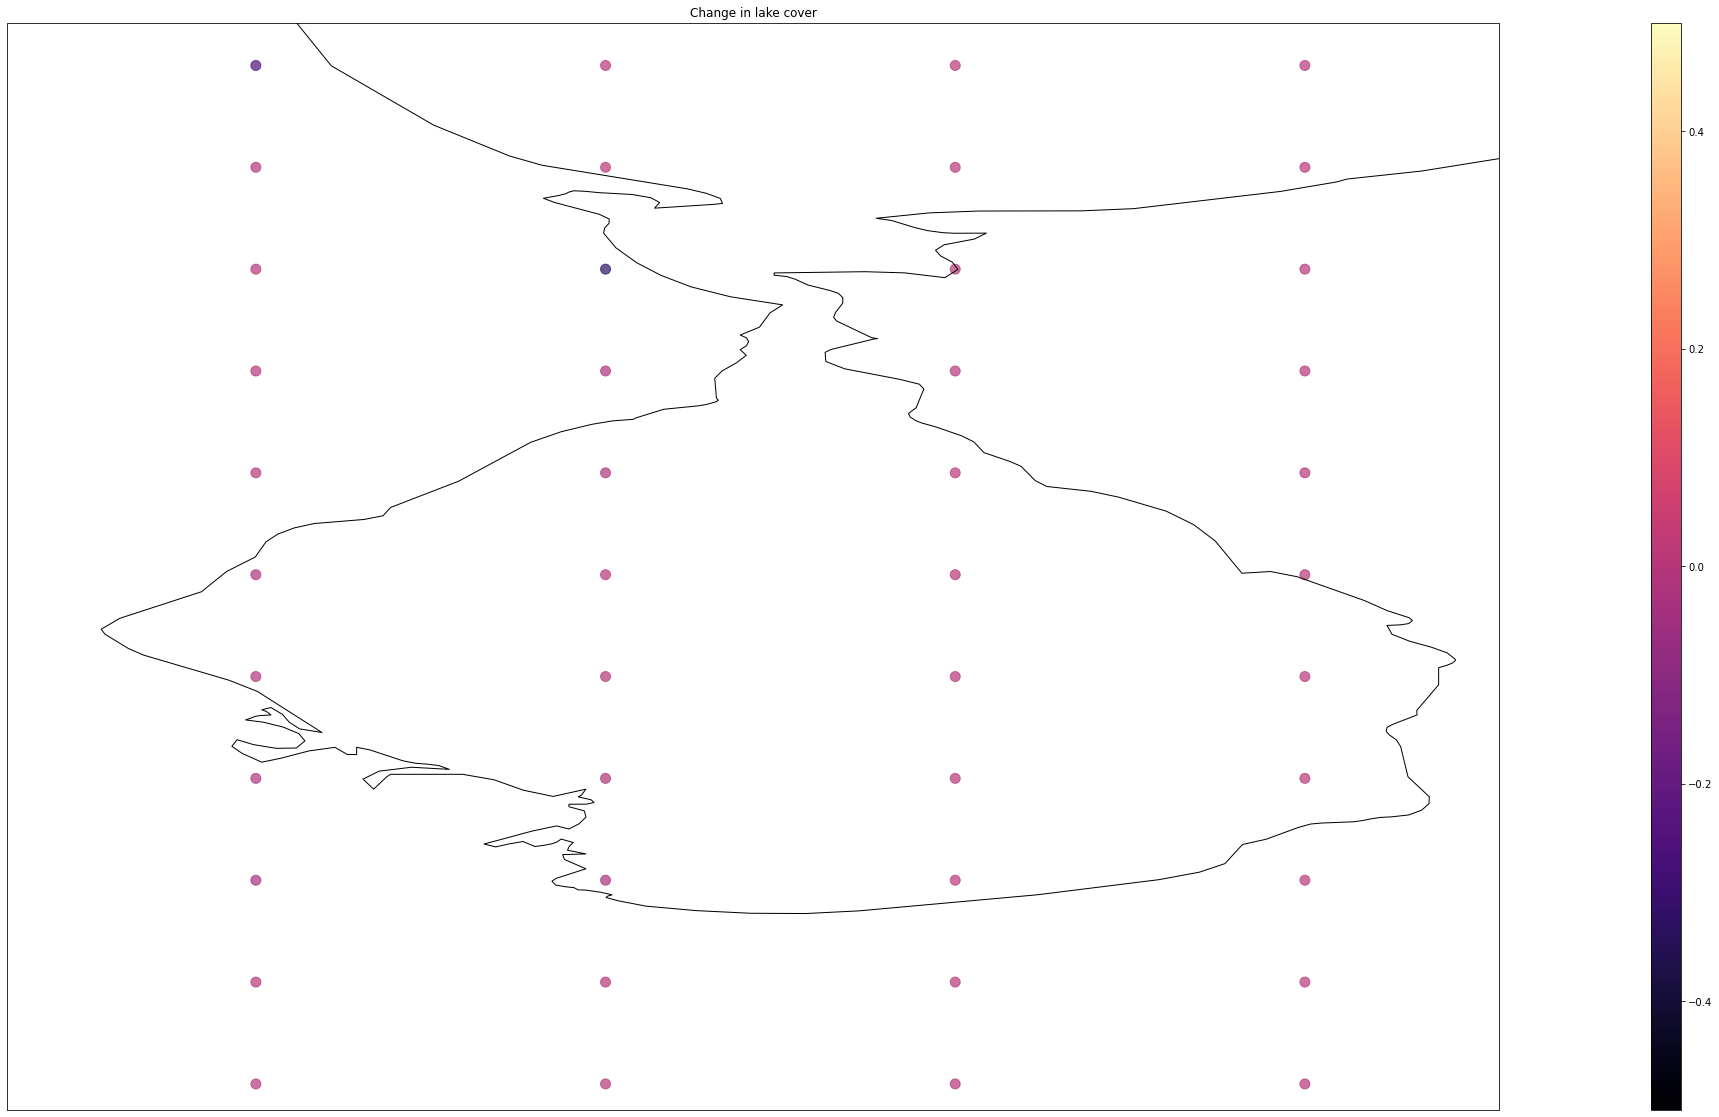

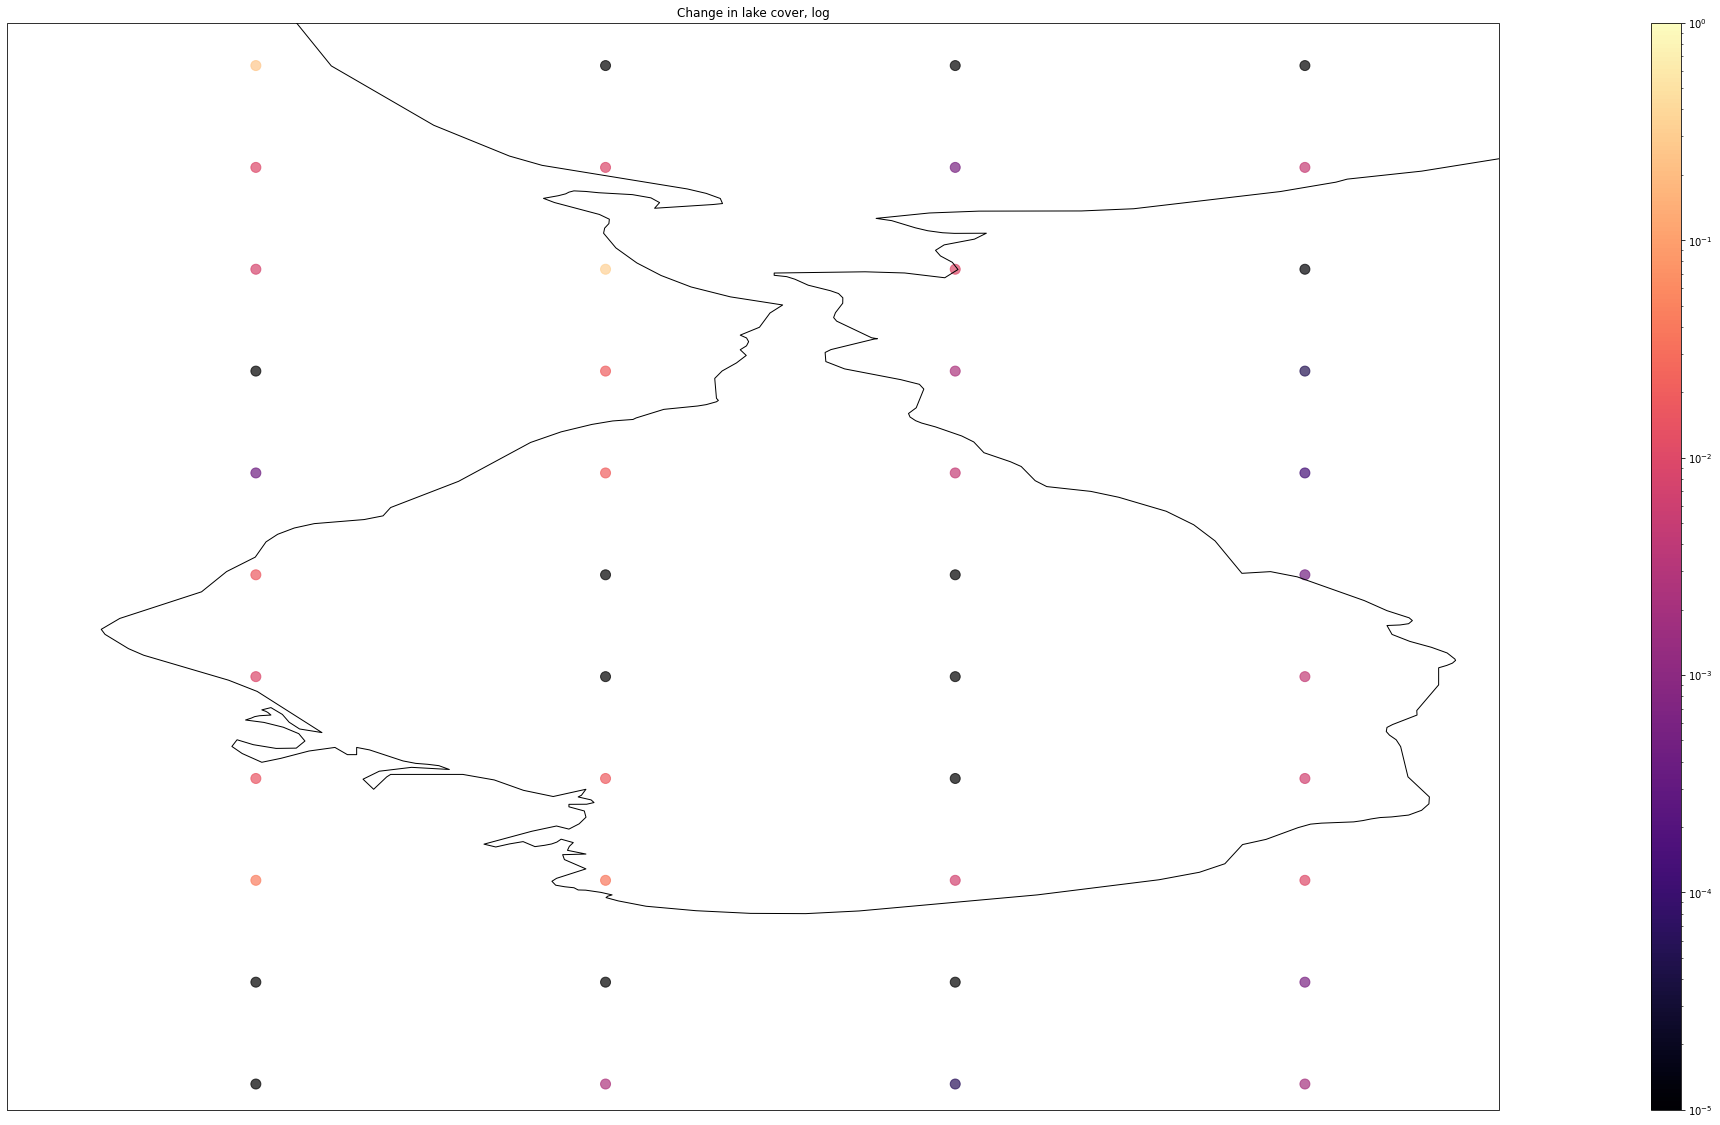

In [24]:

#Setup
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
version = ['v015', 'v020']



ds = [] #Array to hold results
for v in version:
    clake_path = root+f'climate.{v}/climate.{v}/639l_2/clake'
    ds_i= xr.open_dataset(clake_path,engine='cfgrib',backend_kwargs={'indexpath': ''}) 
    ds.append(ds_i)

#Take the difference    
delta = ds[1] - ds[0] #V20 - V15
delta = correct_longitude(delta) #long3 ---> long1

#Plot it
xlow = -72.2
xhigh = -71
ylow = 8.5
yhigh=11.5
limits = {'xlow': xlow,
           'xhigh':xhigh,
           'ylow':ylow,
           'yhigh':yhigh}

#limits = None

plot_map(delta,'cl',vmin=-0.5,vmax=+0.5,cmap=plt.cm.magma,logscale=False,title='Change in lake cover',limits=limits)

#We can also blow up the scale:
plot_map(delta,'cl',vmin=1e-5,vmax=1,cmap=plt.cm.magma,logscale=True,title='Change in lake cover, log',limits=limits)


In [4]:
delta_df = delta.to_dataframe().reset_index()

In [25]:
maracaibo = delta_df.query(f"{ylow} < latitude < {yhigh} & {ylow} < longitude < {yhigh} ")

array([[<AxesSubplot:title={'center':'cl'}>]], dtype=object)

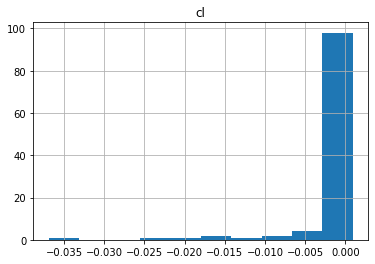

In [26]:
maracaibo.hist(column='cl')